In [229]:
##importing the required libariries##
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn import preprocessing
from sklearn.cross_validation import train_test_split
from sklearn.decomposition import PCA
from sklearn.ensemble.forest import RandomForestRegressor
from sklearn.cross_validation import cross_val_score
import operator
from sklearn.metrics import mean_squared_error
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [222]:
##importing the data into a pandas data frame##
train_DF=pd.read_csv('codetest_train.txt', delimiter='\t')

count    5000.000000
mean        1.143878
std         5.259896
min       -26.705570
25%        -2.034383
50%         1.166835
75%         4.439549
max        26.347818
Name: target, dtype: float64

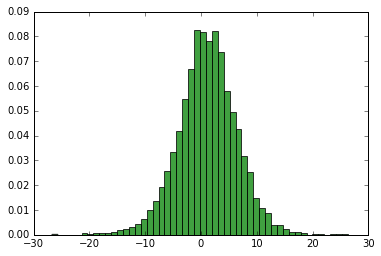

In [223]:
##getting the statistics of the target values to get a better underestanding
#of the proper learning method##
n, bins, patches = plt.hist(train_DF['target'], 50, normed=1, facecolor='green', alpha=0.75)
train_DF['target'].describe()

In [224]:
##splitting the data into train/test set to have a set for performance evaluation##
X_train, X_test, y_train, y_test = train_test_split(train_DF.iloc[:,1:255], \
                                                    train_DF['target'], test_size=0.2)

In [225]:
##data_refine function will: 1-find the non-numeric columns, 2- fill the NaN 
#in non-numeric columns with the most used element 3- transform the non-numeric 
#columns to numeric values using LabelEncoder method from SKLearn, 4- fill the 
#NaN values in the numeric columns using the mean value of them##
def data_refine(train_DF):
    #1-find the non-numeric columns#
    real_or_str=train_DF.applymap(np.isreal).all(0)
    non_num_feature=real_or_str[~real_or_str].keys()
    le = preprocessing.LabelEncoder()
    for col in non_num_feature:
        #2- fill the NaN in non-numeric columns with the most used element#
        train_DF[col].fillna(train_DF[col].describe().top, inplace=True)
        #3- transform the non-numeric columns to numeric values using 
        #LabelEncoder method from SKLearn#
        train_DF[col]=le.fit_transform(train_DF[col])
    #4- fill the NaN values in the numeric columns using the mean value of them
    train_DF.fillna(train_DF.mean(), inplace=True)
    return train_DF

X_train_refined=data_refine(X_train)
X_test_refined=data_refine(X_test)

In [226]:
##Using a Support Vector Regressor as our learning technique##
clf = svm.SVR(C=1, epsilon=0.2)
clf.fit(X_train_refined, y_train)
print ("MSE on the training set is:\n"), mean_squared_error(y_train, \
                                        clf.predict(X_train_refined))
print ("MSE on the test set is:\n"), mean_squared_error(y_test, \
                                        clf.predict(X_test_refined))

MSE on the training set is:
12.0869268614
MSE on the test set is:
17.2529650053


In [227]:
##Using another learning technique (Random Forrest Regressor) on our data##
rfr = RandomForestRegressor(n_estimators=10, random_state=0)
rfr.fit(X_train_refined, y_train)
print ("MSE on the training set is:\n"), mean_squared_error(y_train, \
                                        rfr.predict(X_train_refined))
print ("MSE on the test set is:\n"), mean_squared_error(y_test, \
                                    rfr.predict(X_test_refined))

MSE on the training set is:
2.49144749533
MSE on the test set is:
15.9314309093


**As we can see, both of these models tend to overfit the training set. Linear Regressors/K Nearest Neighbor/Neural Networks yield the same performance and all tend to overfit as well. We will try two different method to overcome overfitting.**

    1- We will try to use PCA to reduce the number of features
    2- We will pick Random Forrest Regressor as our model and using the k-fold cross 
    validation technique fine tune the parameters of the SVR.

In [231]:
##Trying PCA and reducing the number of features and checking if the 
#performance on the test set improves##
for n in [50,100,150,200]:
    pca = PCA(n_components=n)
    rfr.fit(pca.fit_transform(X_train_refined),y_train)
    print "With %d features, %f of variance is preserved and the MSE on\
    the test set is %f"%(n, pca.explained_variance_ratio_.sum(),\
    mean_squared_error(y_test, rfr.predict(pca.fit_transform(X_test_refined)))) 


With 50 features, 0.281870 of variance is preserved and the MSE on    the test set is 36.695022
With 100 features, 0.509171 of variance is preserved and the MSE on    the test set is 36.815525
With 150 features, 0.702820 of variance is preserved and the MSE on    the test set is 36.236900
With 200 features, 0.866501 of variance is preserved and the MSE on    the test set is 36.795260


**We can see that almost all of the columns are containing significant amount of variance/data and even using 200 features we are still losing around 15% of the data. Also the performance of our model doesn't improve by using less features and it still overfit. So, next we try to fine tune the parameters of our RFR model using a 5-fold cross-validation**

In [159]:
##trying different values for n_estimators parameters (number of trees in the forrest) and evaluating the performance 
#using a 5-folded cross validation on the training set##
est_list=[10,20,50,100,200]
score={}
for est in est_list:
    rfr = RandomForestRegressor(n_estimators=est, random_state=0)
    rfr.fit(X_train_refined, y_train)
    score[est]=cross_val_score(rfr, X_train_refined, y_train, cv=5).mean()

In [215]:
##finding the optimal value of n_estimators##
n_est=max(score.iteritems(), key=operator.itemgetter(1))[0]
print "the optimal value of n_estimators=%d"%(n_est)

the optimal value of n_estimators=200


In [232]:
##Using a Random Forest Regressor with the optimal C and epsilon parameters##
rfr = RandomForestRegressor(n_estimators=n_est, random_state=0)
rfr.fit(X_train_refined, y_train)
print ("score on the training set using optimal value of n_estimators is:\n"),\
mean_squared_error(y_train, rfr.predict(X_train_refined))
print ("score on the test set using optimal value of n_estimators is:\n"), \
mean_squared_error(y_test, rfr.predict(X_test_refined))

score on the training set using optimal value of n_estimators is:
1.67265451698
score on the test set using optimal value of n_estimators is:
13.7596595741


**As we can see the performance improvement using a larger number of trees was marginal**

In [233]:
##predicting the target on the given test set and writing the output into a text file##
final_test_DF=pd.read_csv('codetest_test.txt', delimiter='\t')
X_test_final_refined=data_refine(final_test_DF)
predictions=rfr.predict(X_test_final_refined)
f = open('predicted_target_test.txt', 'w')
for pre in predictions:
    f.writelines(str(pre)+'\n')
f.close()